# **Load Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import KMeans
import OptimalK
from transformers import AutoTokenizer, AutoModel
import umap
import plotly.express as px
import re

'''
TODO: Visualize which MDS are most likely to be mixed up

'''

/Users/isabelle_carminati/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\nTODO: Visualize which MDS are most likely to be mixed up\n\n'

# **Data Loading**

In [2]:
path = 'data/data.csv'
df = pd.read_csv(path, encoding='ISO-8859-1') # Using a different encoding while info is fixed
df_win = pd.read_csv(path, encoding='Windows-1252') # For experimental purposes


First we set a path for the data that we want to use.
* We utilize pandas to read the csv file and use a specified encoding.
* This encoding ISO-8859-1 is also known as Latin-1 which is a character encoding standard for Western European Languages.

An encoder allows us to understand the csv file by converting the bytes into readable characters

In [3]:
import chardet

# Open the file in binary mode
with open('data/data.csv', 'rb') as f:
    # Detect encoding
    result = chardet.detect(f.read())
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


Here we run chardet, which is a library that helps detect a file's encoding. 
* It outputs the recommended encoder along with the conifdence

We have the correct encoder!

# **Embeddings Functions**

In [4]:
def GetCategoriesSum(df, category_name: str):
    category = dict()

    for entry in df[category_name]:
        if pd.isnull(entry):
            continue  

        items = entry.split(',')
        for item in items:
            item = item.strip() 
            if item:  
                if item in category:
                    category[item] += 1
                else:
                    category[item] = 1
                    
    return category


def EmbedFrame(df, category_name: str, model: SentenceTransformer):
    embeddings = model.encode(df[category_name].tolist())
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) 
    return embeddings


def CreateCluster(df, embeddings, num_clusters, title):

    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(embeddings)
    cluster_assignments = clustering_model.labels_

    for sentence_id, cluster_id in enumerate(cluster_assignments):
        df.loc[sentence_id, title] = cluster_id


def PrintCluster(cluster):
    for cluster_id, mds_list in cluster.items():
        print(f"\nCluster {cluster_id}:")
        print("-" * 20)
        for mds in mds_list:
            print(f"- {mds}")

def ReduceEmbedding(embedded_text, neighbors=100, min_distance=0.0):
    reducer = umap.UMAP(n_neighbors=neighbors, n_components=2, random_state=42, min_dist=min_distance)
    return reducer.fit_transform(embedded_text)
    
def VisualizeCluster(df, graph_title, reduced_embeddings, cluster_title: str, category: str = "MDS Simplified", show_authors=False, show_country=False, show_sample_size=False, show_patient_count=False, show_control_count=False, show_year=False, show_data_source=False, show_algorithm=False, show_task=False, show_cv=False, show_performance_metric=False, show_dataset=False, show_goal=False, show_wearable=False):
    df[category] = df[category].str.strip().str.upper()
    #Authors	Year	Paper	Country	MDS	Data Source Primary	Data Source Secondary	Algorithm	Task	Cross Validation	Performance Metric	Sample Size	Dataset	Goal	Abstract	Person	Notes	Wearable Location
    plot_df = pd.DataFrame({
        'UMAP1': reduced_embeddings[:, 0],
        'UMAP2': reduced_embeddings[:, 1],
        'MDS Simplified': df[category],
        'Paper': df['Paper'], 
        'MDS': df['MDS'],
        cluster_title: df[cluster_title].astype(str),
        "Authors": df["Authors"],
        "Country": df["Country"],
        "Sample Size": df["Sample Size"],
        "Patient Count": df["Patient Count"],
        "Control Count": df["Control Count"],
        "Year": df["Year"],
        "Data Source Secondary": df["Data Source Secondary"],
        "Algorithm" : df["Algorithm"],
        "Task": df["Task"],
        "CV" : df["Cross Validation"],
        "Performance Metric": df["Performance Metric"],
        "Dataset": df["Dataset"],
        "Goal": df["Goal"],
        "Wearable": df["Wearable Location"]


    })
    
    symbol_map = {
        '0.0': 'circle',
        '1.0': 'square',
        '2.0': 'diamond',
        '3.0': 'triangle-up',
        '4.0': 'star',
        '5.0': 'bowtie',
        '6.0': 'pentagon',
        '7.0': 'triangle-left',
        '8.0': 'diamond-cross',
        '9.0': 'triangle-down',
        '10.0': 'triangle-right',
    }

    fig = px.scatter(
        plot_df, 
        hover_data={'MDS': True, 'Paper': True, "Authors" : show_authors, "Country": show_country, "Sample Size": show_sample_size, "Patient Count": show_patient_count, "Control Count": show_control_count, "Year": show_year, "Data Source Secondary": show_data_source, "Algorithm": show_algorithm, "Task": show_task, "CV": show_cv, "Performance Metric": show_performance_metric, "Dataset": show_dataset, "Goal": show_goal, "Wearable": show_wearable}, 
        x='UMAP1', 
        y='UMAP2', 
        color='MDS Simplified', 
        symbol=cluster_title,   
        symbol_map=symbol_map,   
        title=graph_title,
        labels={"UMAP1": "UMAP Component 1", "UMAP2": "UMAP Component 2"}
    )
    
    fig.update_layout(
        legend_title_text='MDS Simplified and Cluster ID',
        title_font_size=16,
        xaxis_title="UMAP Component 1",
        yaxis_title="UMAP Component 2",
        template="plotly_white"
    )
    
    fig.show()


def GetClusterAccuracy(df, cluster_title):
    total_count = len(df[cluster_title])
    mode_count = df[cluster_title].value_counts().max()
    cluster_accuracy = mode_count / total_count
    return cluster_accuracy

def FormatSampleSize(df):
    patient_list = []
    control_list = []

    for ss in df["Sample Size"]:
        if pd.isnull(ss) or "NA" in str(ss).upper():
            patient_list.append(0)
            control_list.append(0)
            continue
        
        ss = str(ss)
        patient_count = 0
        control_count = 0

        matches = re.findall(r'(\d+)\s*([A-Za-z]*)', ss)
        for num_str, word in matches:
            num = int(num_str)
            if 'CONTROL' in word.upper():
                control_count += num
            else:
                patient_count += num

        patient_list.append(patient_count)
        control_list.append(control_count)
    
    df["Patient Count"] = patient_list
    df["Control Count"] = control_list


def SimplifyMDS(df):
    simplified_list = []
    for mds in df["MDS"]:
        if pd.isnull(mds):
            simplified_list.append(None)
            continue
        mds_upper = mds.strip().upper()
        if "ATAXIA" in mds_upper:
            simplified_list.append("ATAXIA")
        elif "DYSTONIA" in mds_upper:
            simplified_list.append("DYSTONIA")
        elif "BRADYKINESIA" in mds_upper:
            simplified_list.append("BRADYKINESIA")
        elif "TREMOR" in mds_upper:
            simplified_list.append("TREMOR")
        elif "ET" in mds_upper:
            simplified_list.append("ET")
        elif "FOG" in mds_upper:
            simplified_list.append("FOG")
        elif "DYSKINESIA" in mds_upper:
            simplified_list.append("DYSKINESIA")
        else:
            simplified_list.append(mds_upper)

    df["MDS Simplified"] = simplified_list


# **ML VARIABLES**

In [5]:
def strip_whitespace(cell):
    if isinstance(cell, str):  # Check if the value is a string ( if x is str)
        return cell.strip()    # Strip whitespace from strings (leading and trailing)
    return cell                # Return non-strings unchanged

df = df.applymap(strip_whitespace)
df_win = df_win.applymap(strip_whitespace)
df = df.dropna(subset=["Authors"]).reset_index(drop=True)
df_win = df_win.dropna(subset=["Authors"]).reset_index(drop=True)


SimplifyMDS(df)
FormatSampleSize(df)
SimplifyMDS(df_win)
FormatSampleSize(df_win)

/var/folders/pl/_170xqr11jj6znstdq0_l6z80000gn/T/ipykernel_25818/4015442346.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(strip_whitespace)
/var/folders/pl/_170xqr11jj6znstdq0_l6z80000gn/T/ipykernel_25818/4015442346.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_win = df_win.applymap(strip_whitespace)


In [6]:
#model = SentenceTransformer("all-MiniLM-L6-v2") # Change model to bio
#model2 = SentenceTransformer("../models/sentence-transformers/emilyalsentzer_Bio_ClinicalBERTo_ClinicalBERT")
#model2 = SentenceTransformer("monologg/biobert_v1.1_pubmed")

#tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
#model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

model = SentenceTransformer("pritamdeka/S-PubMedBert-MS-MARCO")
'''
- UMAP > t-SNE (better at preserving global structure & performance)
    - Higher n_neighbor --> more global structure
        - Higher noise, focus on large-scale trends
    - Lower min_dist --> tightly packed, highly distinguishable clusters, emphasizing local density.
        - Good for high-dimensional datasets where clusters are more continuous or overlapping.
        - Suitable when your clusters are discrete and well-separated in high-dimensional space.
        - Helpful for applications like classification tasks, where precise boundaries between clusters are desired.

'''

'\n- UMAP > t-SNE (better at preserving global structure & performance)\n    - Higher n_neighbor --> more global structure\n        - Higher noise, focus on large-scale trends\n    - Lower min_dist --> tightly packed, highly distinguishable clusters, emphasizing local density.\n        - Good for high-dimensional datasets where clusters are more continuous or overlapping.\n        - Suitable when your clusters are discrete and well-separated in high-dimensional space.\n        - Helpful for applications like classification tasks, where precise boundaries between clusters are desired.\n\n'

# **GENERAL VISUALIZATION**

In [7]:
type(df['Country'].value_counts())

pandas.core.series.Series

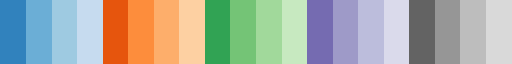

In [8]:
cm.tab20c

**Papers by country**

Amount of Countries: 32
Amount of Papers: 220


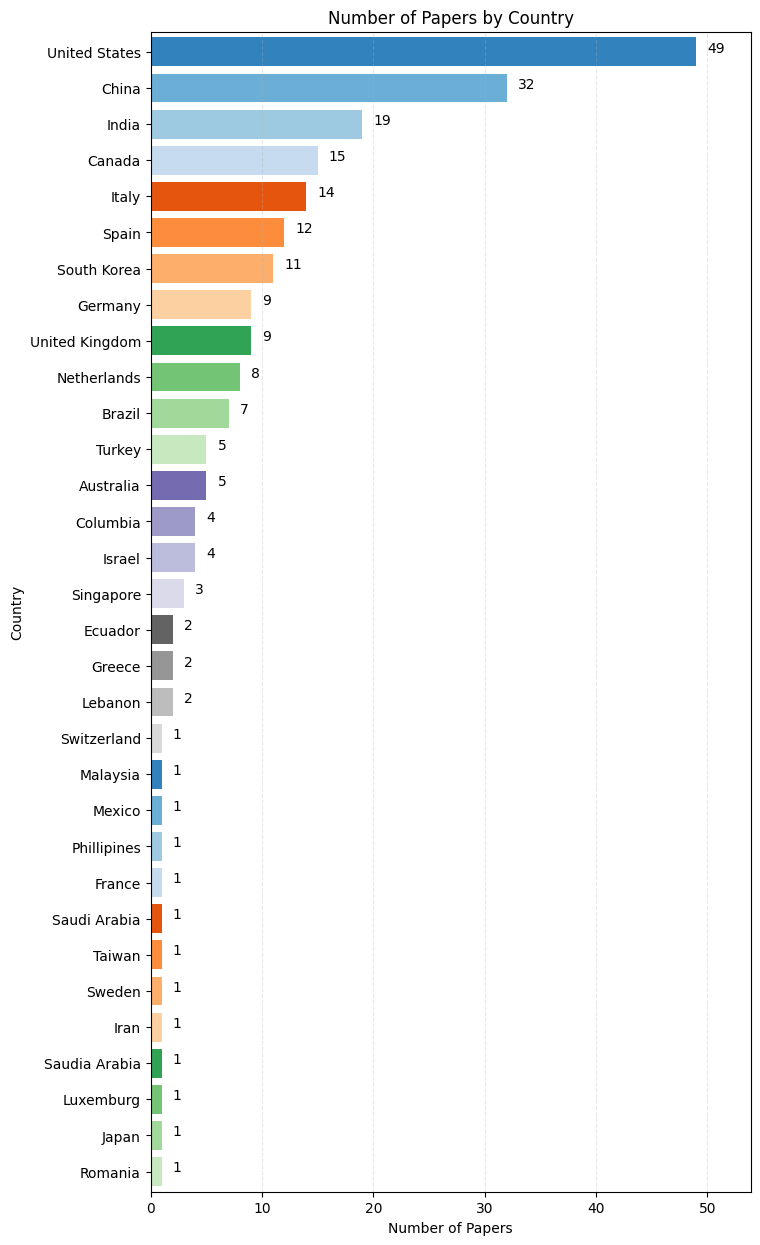

In [9]:
# Plot the horizontal bar graph with spacing between bars
country_counts = df['Country'].value_counts()
print("Amount of Countries:", len(country_counts))  # Prints the length of the list
paper_counts = df['Paper'].value_counts()
print("Amount of Papers:", len(paper_counts))  # Prints the length of the list



plt.figure(figsize=(10, 8))
plt.barh(country_counts.index, country_counts.values, color=cm.tab20c.colors[:len(country_counts)])
# Set the x-axis label
max_count = country_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Country')
plt.title('Number of Papers by Country')

for i, v in enumerate(country_counts.values):
        plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()
plt.show()

**Papers by Person**

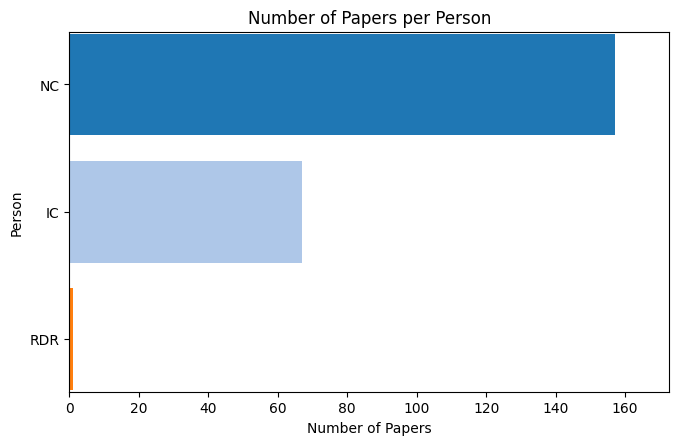

In [10]:
# Plot the horizontal bar graph with spacing between bars
person_counts = df['Person'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(person_counts.index, person_counts.values, color=cm.tab20.colors[:len(person_counts)])
# Set the x-axis label
max_count = person_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Person')
plt.title('Number of Papers per Person')

# for i, v in enumerate(person_counts.values):
#         plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=0.5, bottom=0.05)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

**Data Source Counts**

Amount of Data Source Secondary:  71


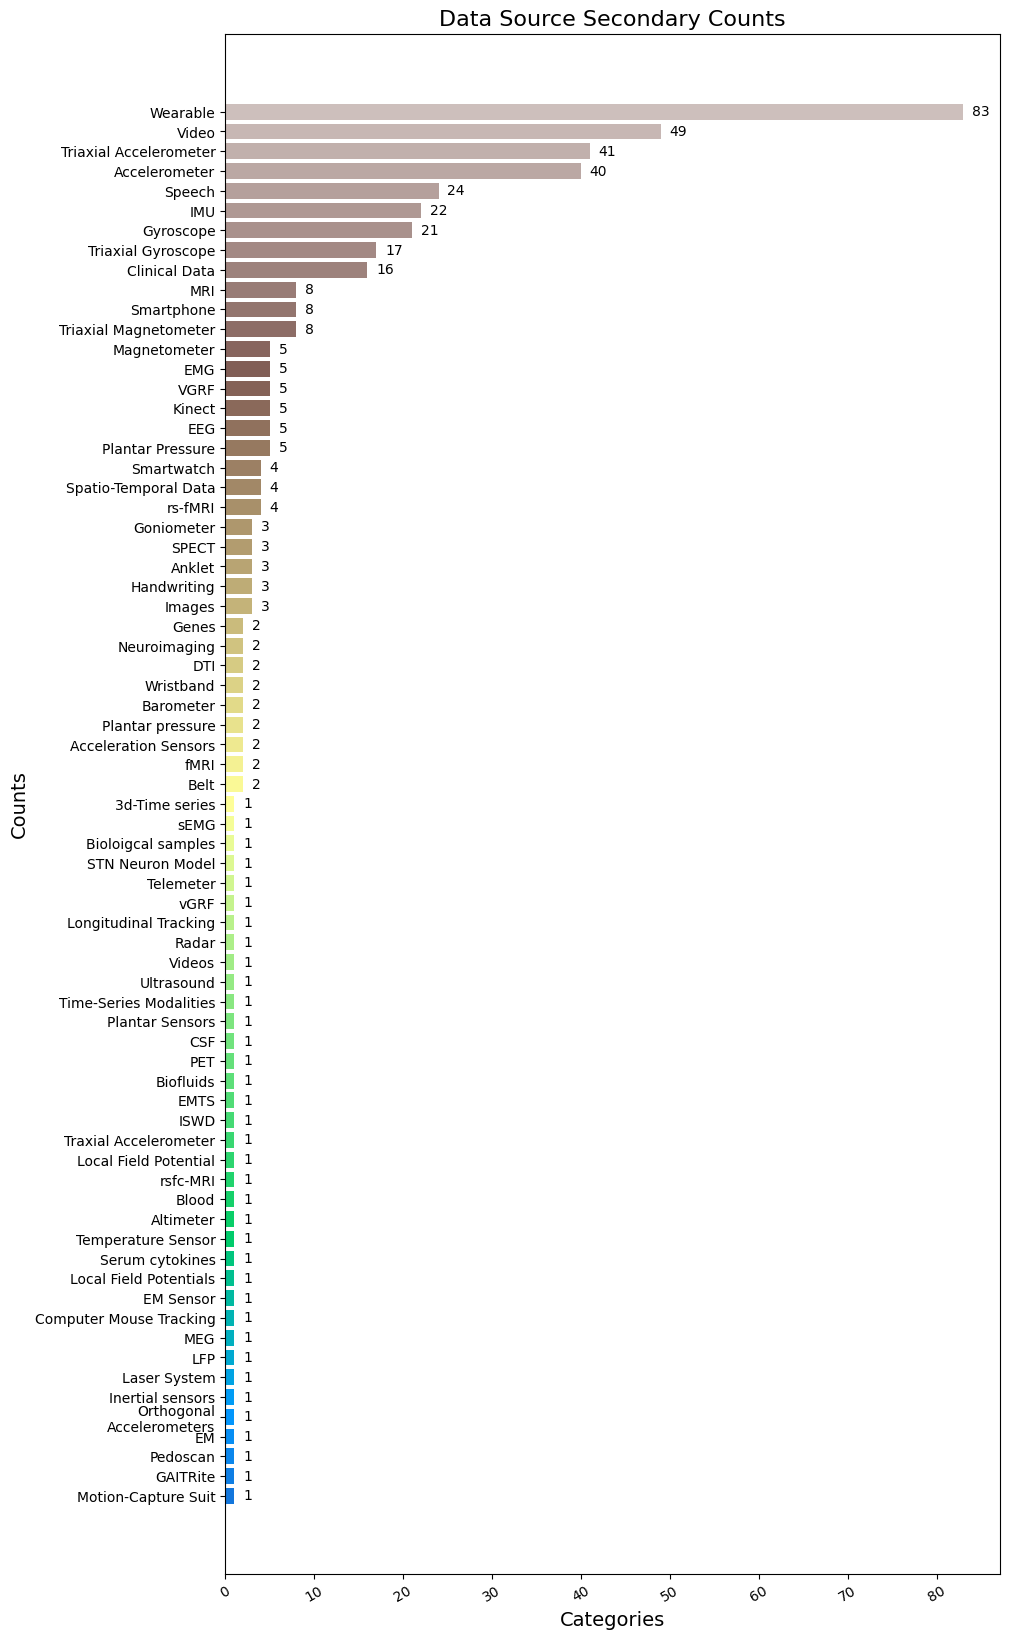

In [11]:
category_counts = GetCategoriesSum(df, "Data Source Secondary")
print("Amount of Data Source Secondary: ",len(category_counts))

# Convert dictionary to Series for plotting
category_counts_series = pd.Series(category_counts)
category_counts_series = category_counts_series.sort_values()

cmap = plt.get_cmap('terrain')  # Choose your colormap
colors = cmap(np.linspace(0.1, 0.9, len(category_counts_series)))  # Adjust the range (e.g., 0.2 to 0.8 for less dominance of one color)

# Plotting the bar chart
plt.figure(figsize=(10, 20))
bars = plt.barh(category_counts_series.index, category_counts_series.values, color = colors)
for bar in bars:
    plt.text(
        bar.get_width() + 1,  # Position text slightly beyond the bar
        bar.get_y() + bar.get_height() / 2,  # Center text vertically
        f'{int(bar.get_width())}',  # Convert value to integer and format
        va='center',  # Vertical alignment
        fontsize=10,  # Font size for the text
        color='black'  # Text color
    )


plt.xlabel('Categories', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Data Source Secondary Counts', fontsize=16)
plt.xticks(rotation=30)
plt.show()

*Top 20*

Data Source Secondary Total: 71


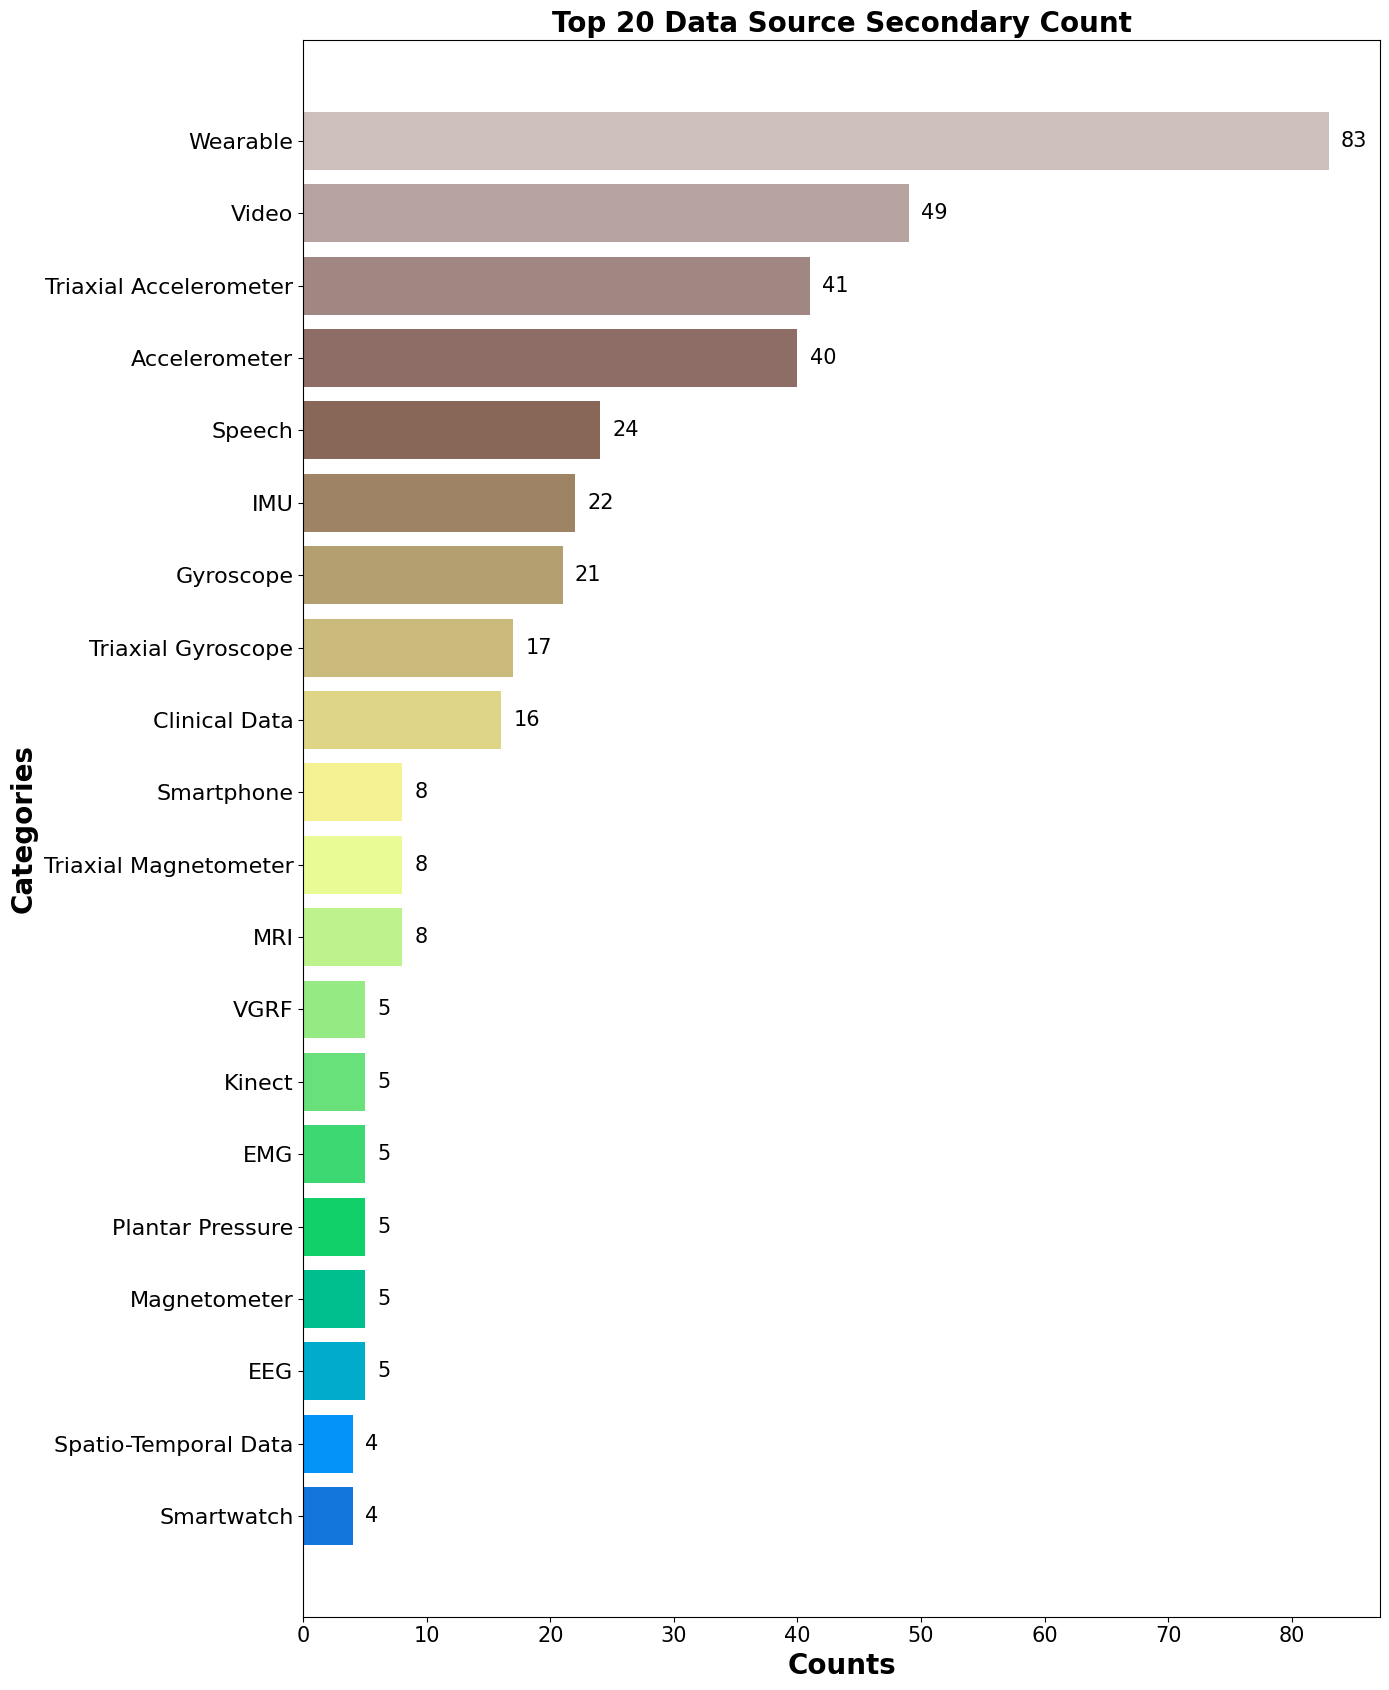

In [12]:
category_counts = GetCategoriesSum(df_win, "Data Source Secondary")
print("Data Source Secondary Total:", len(category_counts))

# Convert dictionary to Series for plotting
category_counts_series = pd.Series(category_counts)

# Sort values in ascending order and select the top 20
top_20 = category_counts_series.sort_values(ascending=False).head(20).sort_values()

# Generate a gradient color for the top 20
cmap = plt.get_cmap('terrain') 
colors = cmap(np.linspace(0.1, 0.9, len(top_20)))

# Plotting the bar chart for the top 20
plt.figure(figsize=(14, 17))  # Adjust figure size for fewer bars
bars = plt.barh(top_20.index, top_20.values, color=colors)
for bar in bars:
    plt.text(
        bar.get_width() + 1,  # Position text slightly beyond the bar
        bar.get_y() + bar.get_height() / 2,  # Center text vertically
        f'{int(bar.get_width())}',  # Convert value to integer and format
        va='center',  # Vertical alignment
        fontsize=15,  # Font size for the text
        color='black'  # Text color
    )


plt.xlabel('Counts', fontsize=20, fontweight='bold')
plt.ylabel('Categories', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=15)
plt.title('Top 20 Data Source Secondary Count', fontsize=20, fontweight='bold')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

**Machine Learning Algorithms**

Amount of Algorithms: 167


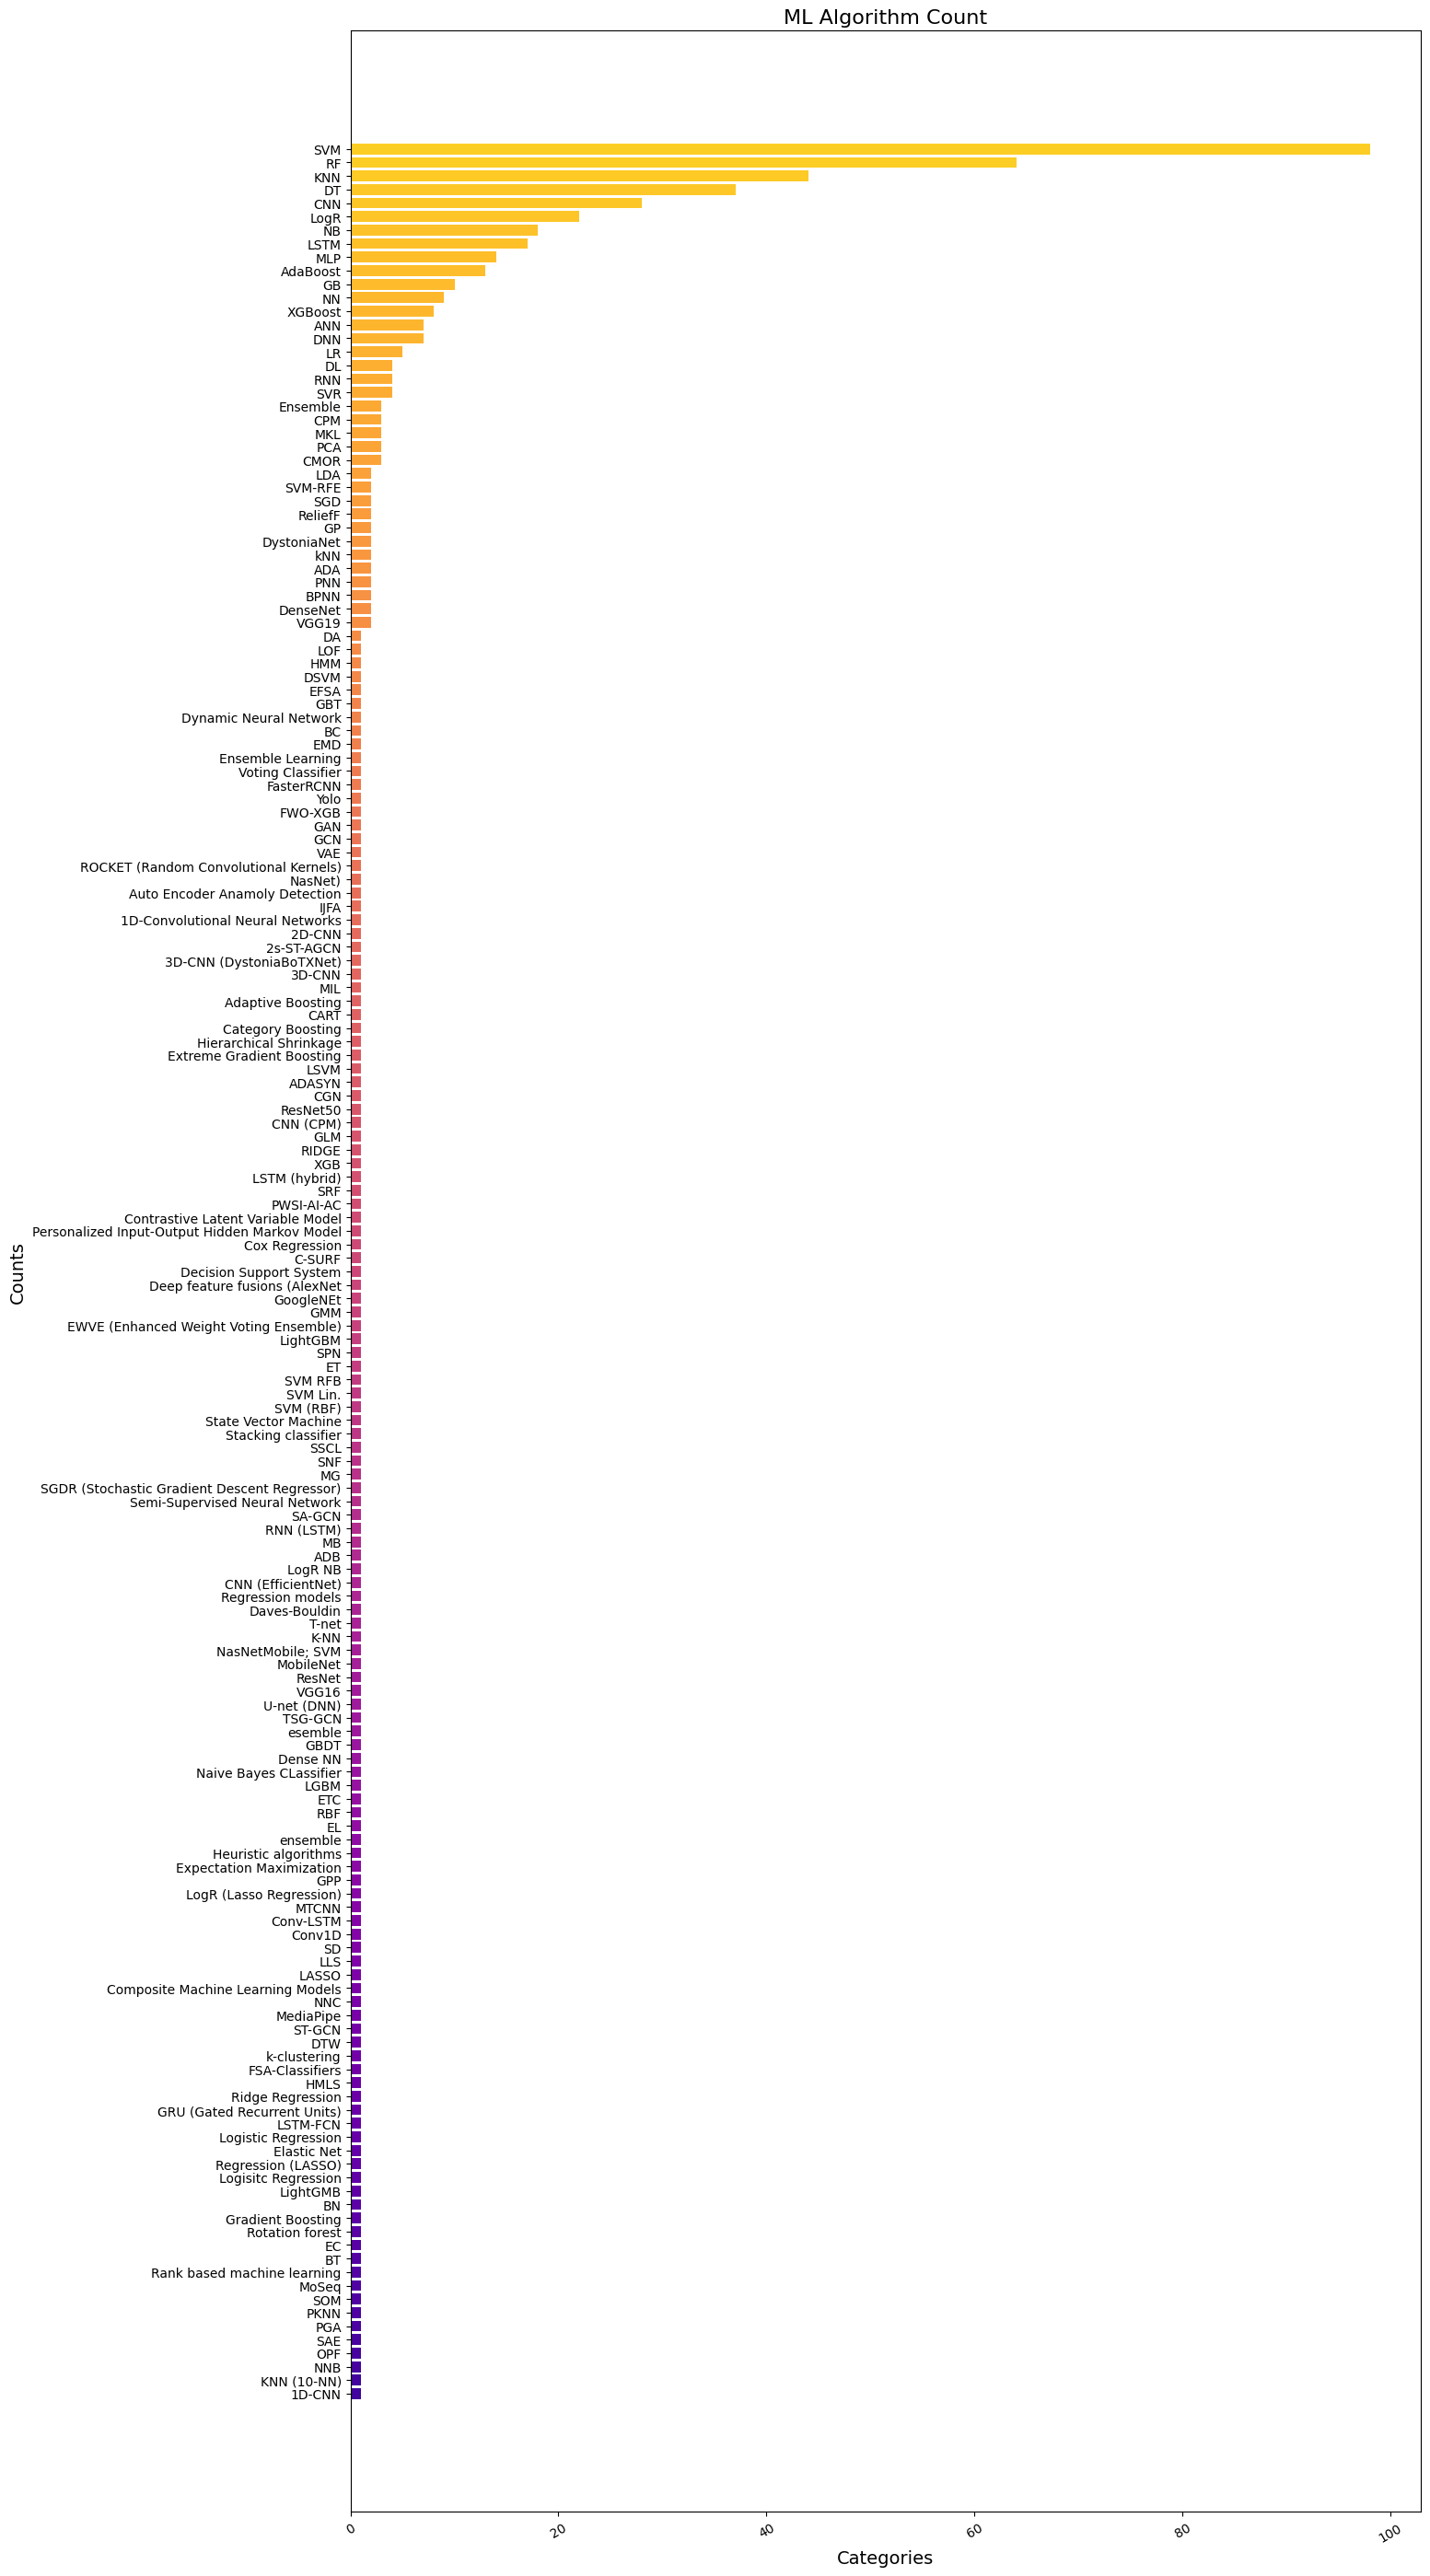

In [13]:
category_counts = GetCategoriesSum(df_win, "Algorithm")
print("Amount of Algorithms:", len(category_counts))  # Prints the length of the list
# Convert dictionary to Series for plotting
category_counts_series = pd.Series(category_counts)
category_counts_series = category_counts_series.sort_values()


cmap = plt.get_cmap('plasma')  # Choose your colormap
colors = cmap(np.linspace(0.1, 0.9, len(category_counts_series)))  # Adjust the range (e.g., 0.2 to 0.8 for less dominance of one color)

# Plotting the bar chart
plt.figure(figsize=(15, 35))
plt.barh(category_counts_series.index, category_counts_series.values, color=colors)
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('ML Algorithm Count', fontsize=16)
plt.xticks(rotation=30)

plt.show()


*Top 20*

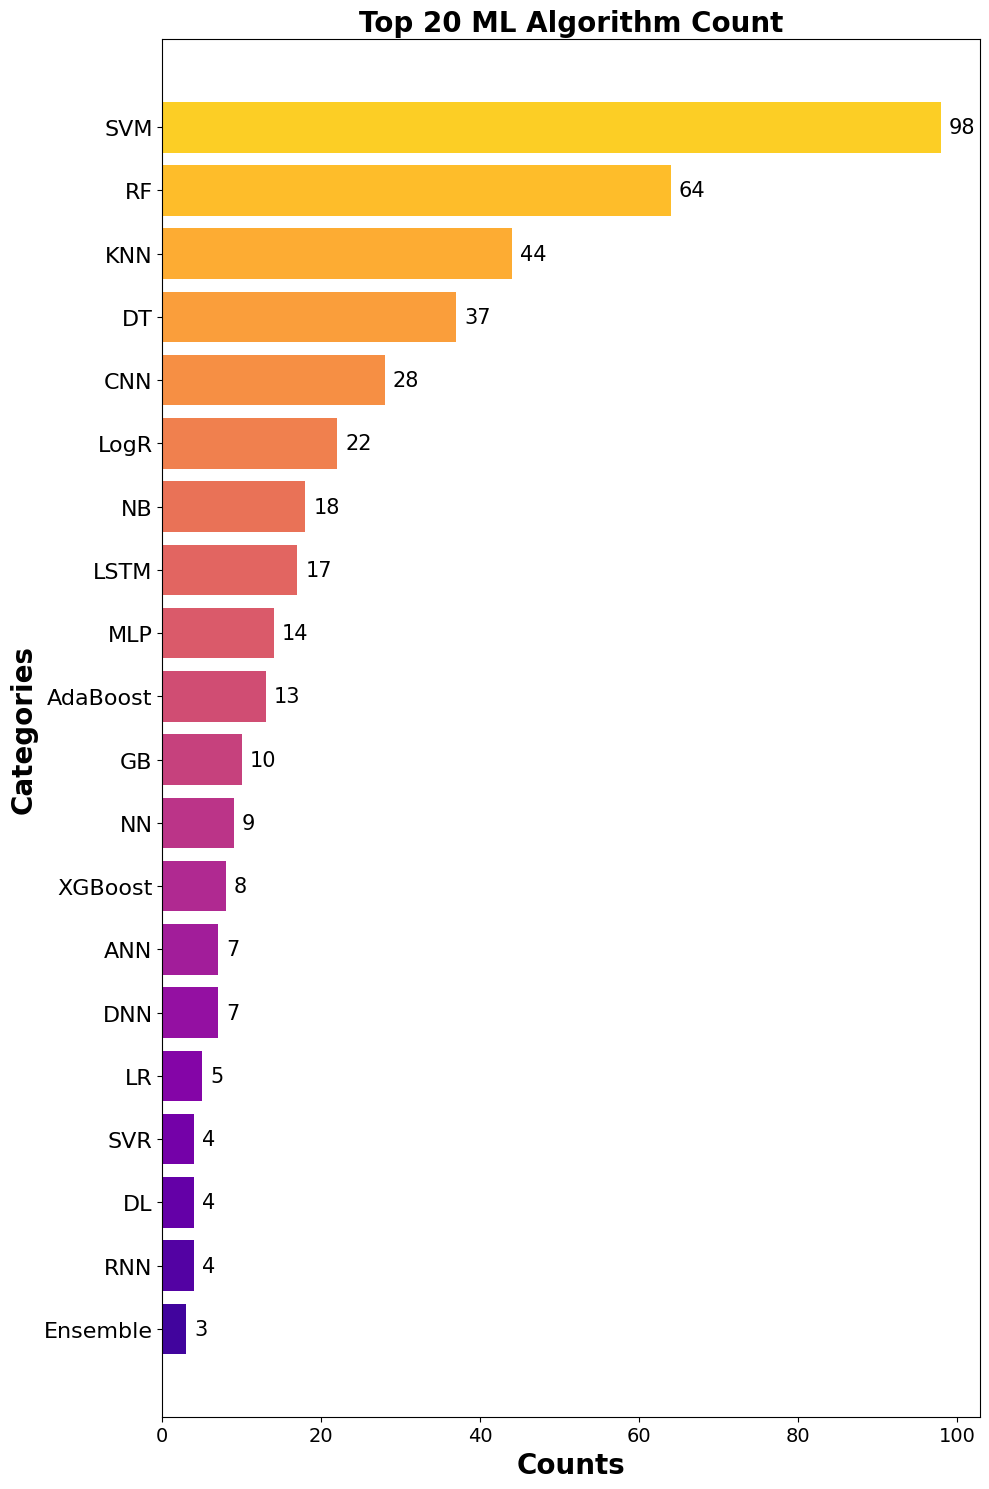

In [14]:
category_counts = GetCategoriesSum(df_win, "Algorithm")

# Convert dictionary to Series for plotting
category_counts_series = pd.Series(category_counts)

# Sort values in ascending order and select the top 20
top_20 = category_counts_series.sort_values(ascending=False).head(20).sort_values()

# Generate a gradient color for the top 20
cmap = plt.get_cmap('plasma') 
colors = cmap(np.linspace(0.1, 0.9, len(top_20)))

# Plotting the bar chart for the top 20
plt.figure(figsize=(10, 15))  # Adjust figure size for fewer bars
bars = plt.barh(top_20.index, top_20.values, color=colors)
for bar in bars:
    plt.text(
        bar.get_width() + 1,  # Position text slightly beyond the bar
        bar.get_y() + bar.get_height() / 2,  # Center text vertically
        f'{int(bar.get_width())}',  # Convert value to integer and format
        va='center',  # Vertical alignment
        fontsize=15,  # Font size for the text
        color='black'  # Text color
    )

plt.xlabel('Counts', fontsize=20, fontweight ='bold')
plt.ylabel('Categories', fontsize=20, fontweight ='bold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
plt.title('Top 20 ML Algorithm Count', fontsize=20, fontweight ='bold')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

**MDS**

Amount of MDS: 16


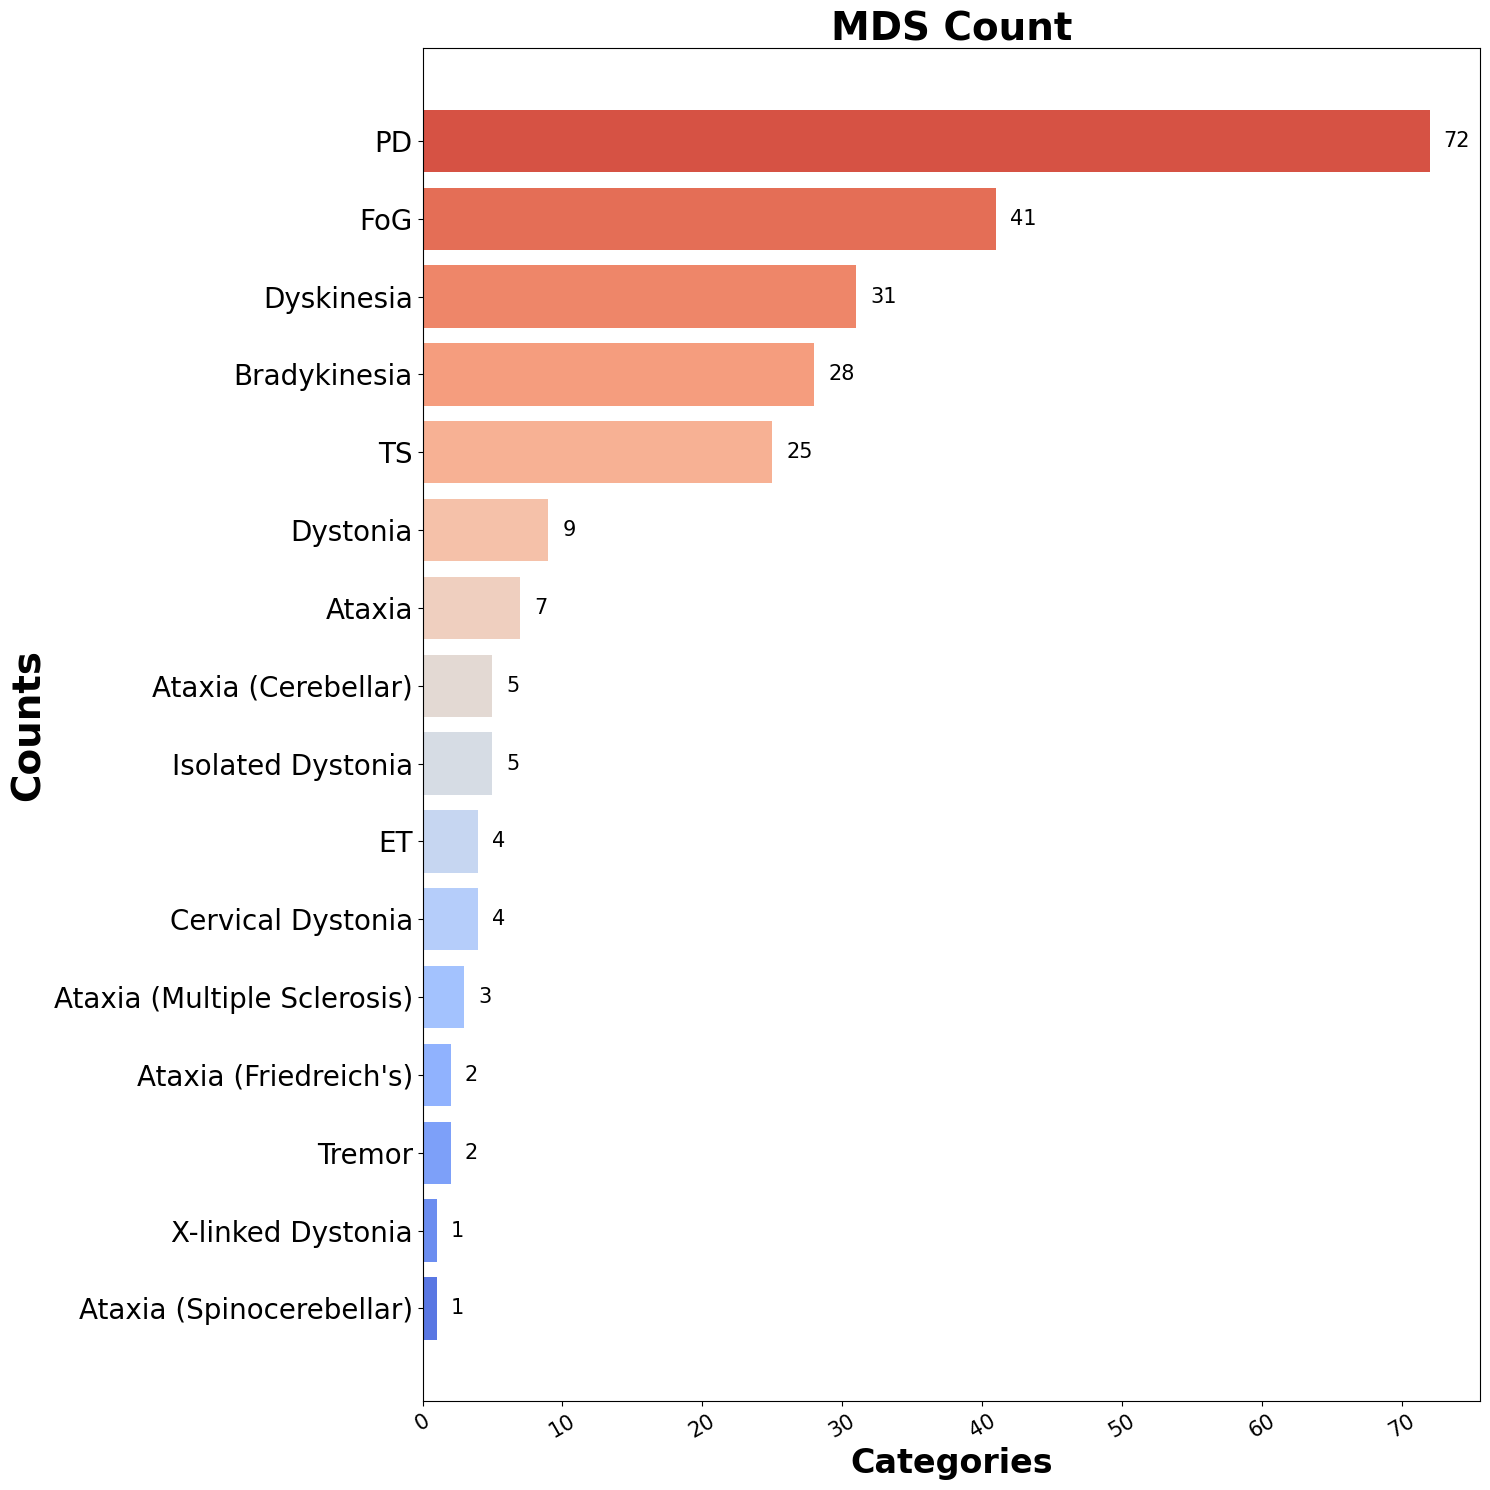

In [15]:
category_counts = GetCategoriesSum(df_win, "MDS")
print("Amount of MDS:", len(category_counts))  # Prints the length of the list
# Convert dictionary to Series for plotting
category_counts_series = pd.Series(category_counts)
category_counts_series = category_counts_series.sort_values()


cmap = plt.get_cmap('coolwarm')  # Choose your colormap
colors = cmap(np.linspace(0.1, 0.9, len(category_counts_series)))  # Adjust the range (e.g., 0.2 to 0.8 for less dominance of one color)

# Plotting the bar chart
plt.figure(figsize=(15, 15))
bars = plt.barh(category_counts_series.index, category_counts_series.values, color=colors)
for bar in bars:
    plt.text(
        bar.get_width() + 1,  # Position text slightly beyond the bar
        bar.get_y() + bar.get_height() / 2,  # Center text vertically
        f'{int(bar.get_width())}',  # Convert value to integer and format
        va='center',  # Vertical alignment
        fontsize=15,  # Font size for the text
        color='black'  # Text color
    )

plt.xlabel('Categories', fontsize=24, fontweight = 'bold')
plt.xticks(fontsize=15,rotation=30)
plt.ylabel('Counts', fontsize=28, fontweight = 'bold')
plt.yticks(fontsize=20)
plt.title('MDS Count', fontsize=28, fontweight = 'bold')

plt.tight_layout()
plt.show()


# DF encoder difference


For experimental purposes- we can see if there is any major or slight differences by choosing a different encoder


# **PAPER**

## Original ISO encoder

In [16]:
df["Paper"] = df["Paper"].fillna("")
embedded_papers_original = EmbedFrame(df, "Paper", model)
embedded_reduced_papers_original = ReduceEmbedding(embedded_papers_original, neighbors=100, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_papers_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_papers_original, num_clusters, "Reduced Paper Cluster")
VisualizeCluster(df, "Title", embedded_reduced_papers_original, "Reduced Paper Cluster")

print("Toal clusters: ",num_clusters)

/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after pa

Toal clusters:  9


## Windows encoder

In [17]:
df_win["Paper"] = df_win["Paper"].fillna("")
embedded_papers_win = EmbedFrame(df_win, "Paper", model)
embedded_reduced_papers_win = ReduceEmbedding(embedded_papers_win, neighbors=100, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_papers_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_papers_win, num_clusters, "Reduced Paper Cluster")
VisualizeCluster(df_win, "Title", embedded_reduced_papers_win, "Reduced Paper Cluster")

print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


# **AUTHORS**

## Original ISO encoder

In [18]:
df["Authors"] = df["Authors"].fillna("")
embedded_authors_original = EmbedFrame(df, "Authors", model)
embedded_reduced_authors_original = ReduceEmbedding(embedded_authors_original, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_authors_original, n_refs=50, cluster_array=np.arange(1,10))
print("Toal clusters: ",num_clusters)
CreateCluster(df, embedded_reduced_authors_original, num_clusters, "Reduced Authors Cluster")
VisualizeCluster(df, "Authors", embedded_reduced_authors_original, "Reduced Authors Cluster", show_authors=True)

/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  3


## Windows encoder

In [19]:
df_win["Authors"] = df_win["Authors"].fillna("")
embedded_authors_win = EmbedFrame(df_win, "Authors", model)
embedded_reduced_authors_win = ReduceEmbedding(embedded_authors_win, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_authors_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_authors_win, num_clusters, "Reduced Authors Cluster")
VisualizeCluster(df_win, "Authors", embedded_reduced_authors_win, "Reduced Authors Cluster", show_authors=True)

print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  6


# **ABSTRACT**

## Original ISO encoder

In [20]:
df["Abstract"] = df["Abstract"].fillna("")
embedded_abstracts_original = EmbedFrame(df, "Abstract", model)
embedded_reduced_abstracts_original = ReduceEmbedding(embedded_abstracts_original, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_abstracts_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_abstracts_original, num_clusters, "Reduced Abstract Cluster")
VisualizeCluster(df, "Abstract", embedded_reduced_abstracts_original, "Reduced Abstract Cluster")

print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


## Windows encoder

In [21]:
df_win["Abstract"] = df_win["Abstract"].fillna("")
embedded_abstracts_win = EmbedFrame(df_win, "Abstract", model)
embedded_reduced_abstracts_win = ReduceEmbedding(embedded_abstracts_win, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_abstracts_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_abstracts_win, num_clusters, "Reduced Abstract Cluster")
VisualizeCluster(df_win, "Abstract", embedded_reduced_abstracts_win, "Reduced Abstract Cluster")
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  8


# **COUNTRY**

## Original ISO encoder

In [22]:
df["Country"] = df["Country"].fillna("")
embedded_countries_original = EmbedFrame(df, "Country", model)
embedded_reduced_countries_original = ReduceEmbedding(embedded_countries_original, neighbors=12, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_countries_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_countries_original, num_clusters, "Reduced Country Cluster")
VisualizeCluster(df, "Country", embedded_reduced_countries_original, "Reduced Country Cluster", show_country=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


In [23]:
df["Country"] = df["Country"].fillna("")
embedded_countries_original = EmbedFrame(df, "Country", model)
embedded_reduced_countries_original = ReduceEmbedding(embedded_countries_original, neighbors=12, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_countries_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_countries_original, num_clusters, "Reduced Country Cluster")
VisualizeCluster(df, "Country", embedded_reduced_countries_original, "Reduced Country Cluster", show_country=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  8


## Windows encoder

In [24]:
df_win["Country"] = df_win["Country"].fillna("")
embedded_countries_win = EmbedFrame(df_win, "Country", model)
embedded_reduced_countries_win = ReduceEmbedding(embedded_countries_win, neighbors=12, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_countries_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_countries_win, num_clusters, "Reduced Country Cluster")
VisualizeCluster(df_win, "Country", embedded_reduced_countries_win, "Reduced Country Cluster", show_country=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


# **DATA SOURCE SECONDARY**

## Original ISO encoder

In [25]:
df["Data Source Secondary"] = df["Data Source Secondary"].fillna("")
embedded_dss_original = EmbedFrame(df, "Data Source Secondary", model)
embedded_reduced_dss_original = ReduceEmbedding(embedded_dss_original, neighbors=10, min_distance=.45)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_dss_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_dss_original, num_clusters, "Reduced Data Source Secondary Cluster")
VisualizeCluster(df, "Data Source Secondary", embedded_reduced_dss_original, "Reduced Data Source Secondary Cluster", show_data_source=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


## Windows encoder

In [26]:
df_win["Data Source Secondary"] = df_win["Data Source Secondary"].fillna("")
embedded_dss_win = EmbedFrame(df_win, "Data Source Secondary", model)
embedded_reduced_dss_win = ReduceEmbedding(embedded_dss_win, neighbors=10, min_distance=.45)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_dss_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_dss_win, num_clusters, "Reduced Data Source Secondary Cluster")
VisualizeCluster(df_win, "Data Source Secondary", embedded_reduced_dss_win, "Reduced Data Source Secondary Cluster", show_data_source=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  7


# **ALGORITHM**

## Original ISO encoder

In [27]:
df["Algorithm"] = df["Algorithm"].fillna("")
embedded_algorithms_original = EmbedFrame(df, "Algorithm", model)
embedded_reduced_algorithms_original = ReduceEmbedding(embedded_algorithms_original, neighbors=10, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_algorithms_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_algorithms_original, num_clusters, "Reduced Algorithm Cluster")
VisualizeCluster(df, "Algorithm", embedded_reduced_algorithms_original, "Reduced Algorithm Cluster", show_algorithm=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  8


## Windows encoder

In [28]:
df_win["Algorithm"] = df_win["Algorithm"].fillna("")
embedded_algorithms_win = EmbedFrame(df_win, "Algorithm", model)
embedded_reduced_algorithms_win = ReduceEmbedding(embedded_algorithms_win, neighbors=10, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_algorithms_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_algorithms_win, num_clusters, "Reduced Algorithm Cluster")
VisualizeCluster(df_win, "Algorithm", embedded_reduced_algorithms_win, "Reduced Algorithm Cluster", show_algorithm=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  6


# **TASK**

## Original ISO encoder

In [29]:
df["Task"] = df["Task"].fillna("")
embedded_tasks_original = EmbedFrame(df, "Task", model)
embedded_reduced_tasks_original = ReduceEmbedding(embedded_tasks_original, neighbors=5, min_distance=.35)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_tasks_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_tasks_original, num_clusters, "Reduced Task Cluster")
VisualizeCluster(df, "Task", embedded_reduced_tasks_original, "Reduced Task Cluster", show_task=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


## Windows encoder

In [30]:
df_win["Task"] = df_win["Task"].fillna("")
embedded_tasks_win = EmbedFrame(df_win, "Task", model)
embedded_reduced_tasks_win = ReduceEmbedding(embedded_tasks_win, neighbors=5, min_distance=.35)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_tasks_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_tasks_win, num_clusters, "Reduced Task Cluster")
VisualizeCluster(df_win, "Task", embedded_reduced_tasks_win, "Reduced Task Cluster", show_task=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


# **CROSS VALIDATION**

## Original ISO encoder

In [31]:
df["Cross Validation"] = df["Cross Validation"].fillna("")
embedded_cvs_original = EmbedFrame(df, "Cross Validation", model)
embedded_reduced_cvs_original = ReduceEmbedding(embedded_cvs_original, neighbors=500, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_cvs_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_cvs_original, num_clusters, "Reduced Cross Validation Cluster")
VisualizeCluster(df, "Cross Validation", embedded_reduced_cvs_original, "Reduced Cross Validation Cluster", show_cv=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



Toal clusters:  8


## Windows encoder

In [32]:
df_win["Cross Validation"] = df_win["Cross Validation"].fillna("")
embedded_cvs_win = EmbedFrame(df_win, "Cross Validation", model)
embedded_reduced_cvs_win = ReduceEmbedding(embedded_cvs_win, neighbors=500, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_cvs_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_cvs_win, num_clusters, "Reduced Cross Validation Cluster")
VisualizeCluster(df_win, "Cross Validation", embedded_reduced_cvs_win, "Reduced Cross Validation Cluster", show_cv=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



Toal clusters:  9


# **PERFORMANCE METRIC**

## Original ISO encoder

In [33]:
df["Performance Metric"] = df["Performance Metric"].fillna("")
embedded_pms_original = EmbedFrame(df, "Performance Metric", model)
embedded_reduced_pms_original = ReduceEmbedding(embedded_pms_original, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_pms_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_pms_original, num_clusters, "Reduced Performance Metric Cluster")
VisualizeCluster(df, "Performance Metric", embedded_reduced_pms_original, "Reduced Performance Metric Cluster", show_performance_metric=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  7


## Windows encoder

In [34]:
df_win["Performance Metric"] = df_win["Performance Metric"].fillna("")
embedded_pms_win = EmbedFrame(df_win, "Performance Metric", model)
embedded_reduced_pms_win = ReduceEmbedding(embedded_pms_win, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_pms_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_pms_win, num_clusters, "Reduced Performance Metric Cluster")
VisualizeCluster(df_win, "Performance Metric", embedded_reduced_pms_win, "Reduced Performance Metric Cluster", show_performance_metric=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


In [35]:
''' TODO: Use Scatter Plot w/ Integers
df["Sample Size"] = df["Sample Size"].fillna("")

embedded_patient_count = EmbedFrame(df, "Patient Count", model)
embedded_control_count = EmbedFrame(df, "Control Count", model)

embedded_reduced_patient_count = ReduceEmbedding(embedded_patient_count, neighbors=50, min_distance=0)
embedded_reduced_control_count = ReduceEmbedding(embedded_control_count, neighbors=50, min_distance=0)

embedded_sample_size = np.concatenate((embedded_reduced_patient_count, embedded_reduced_control_count), axis=1)

optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_sample_size, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_sample_size, num_clusters, "Reduced Patient Count Cluster")
VisualizeCluster(df, "Patient Count", embedded_sample_size, "Reduced Patient Count Cluster")
'''

' TODO: Use Scatter Plot w/ Integers\ndf["Sample Size"] = df["Sample Size"].fillna("")\n\nembedded_patient_count = EmbedFrame(df, "Patient Count", model)\nembedded_control_count = EmbedFrame(df, "Control Count", model)\n\nembedded_reduced_patient_count = ReduceEmbedding(embedded_patient_count, neighbors=50, min_distance=0)\nembedded_reduced_control_count = ReduceEmbedding(embedded_control_count, neighbors=50, min_distance=0)\n\nembedded_sample_size = np.concatenate((embedded_reduced_patient_count, embedded_reduced_control_count), axis=1)\n\noptimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend=\'joblib\')\nnum_clusters = optimalKObj(embedded_sample_size, n_refs=50, cluster_array=np.arange(1,10))\nCreateCluster(df, embedded_sample_size, num_clusters, "Reduced Patient Count Cluster")\nVisualizeCluster(df, "Patient Count", embedded_sample_size, "Reduced Patient Count Cluster")\n'

# **DATASET**

## Original ISO encoder

In [36]:
#TODO: Write out full dataset acronym
df["Dataset"] = df["Dataset"].fillna("")
embedded_datasets_original = EmbedFrame(df, "Dataset", model)
embedded_reduced_datasets_original = ReduceEmbedding(embedded_datasets_original, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_datasets_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_datasets_original, num_clusters, "Reduced Dataset Cluster")
VisualizeCluster(df, "Dataset", embedded_reduced_datasets_original, "Reduced Dataset Cluster", show_dataset=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


## Windows encoder

In [37]:
#TODO: Write out full dataset acronym
df_win["Dataset"] = df_win["Dataset"].fillna("")
embedded_datasets_win = EmbedFrame(df_win, "Dataset", model)
embedded_reduced_datasets_win = ReduceEmbedding(embedded_datasets_win, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_datasets_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_datasets_win, num_clusters, "Reduced Dataset Cluster")
VisualizeCluster(df_win, "Dataset", embedded_reduced_datasets_win, "Reduced Dataset Cluster", show_dataset=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  3


# **GOAL**

## Original ISO encoder

In [38]:
df["Goal"] = df["Goal"].fillna("")
embedded_goals_original = EmbedFrame(df, "Goal", model)
embedded_reduced_goals_original = ReduceEmbedding(embedded_goals_original, neighbors=2, min_distance=.5)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_goals_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_goals_original, num_clusters, "Reduced Goal Cluster")
VisualizeCluster(df, "Goal", embedded_reduced_goals_original, "Reduced Goal Cluster", show_goal=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  6


## Windows encoder

In [39]:
df_win["Goal"] = df_win["Goal"].fillna("")
embedded_goals_win = EmbedFrame(df_win, "Goal", model)
embedded_reduced_goals_win = ReduceEmbedding(embedded_goals_win, neighbors=2, min_distance=.5)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_goals_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_goals_win, num_clusters, "Reduced Goal Cluster")
VisualizeCluster(df_win, "Goal", embedded_reduced_goals_win, "Reduced Goal Cluster", show_goal=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  2


# **WEARABLE LOCATION**

## Original ISO encoder

In [40]:
df["Wearable Location"] = df["Wearable Location"].fillna("")
embedded_wearable_locs_original = EmbedFrame(df, "Wearable Location", model)
embedded_reduced_wearable_locs_original = ReduceEmbedding(embedded_wearable_locs_original, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_wearable_locs_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_wearable_locs_original, num_clusters, "Reduced Wearable Location Cluster")
VisualizeCluster(df, "Wearable Location", embedded_reduced_wearable_locs_original, "Reduced Wearable Location Cluster", show_wearable=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  7


## Windows encoder

In [41]:
df_win["Wearable Location"] = df_win["Wearable Location"].fillna("")
embedded_wearable_locs_win = EmbedFrame(df_win, "Wearable Location", model)
embedded_reduced_wearable_locs_win = ReduceEmbedding(embedded_wearable_locs_win, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_wearable_locs_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_wearable_locs_win, num_clusters, "Reduced Wearable Location Cluster")
VisualizeCluster(df_win, "Wearable Location", embedded_reduced_wearable_locs_win, "Reduced Wearable Location Cluster", show_wearable=True)
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  7


# **HIGH DIMENSIONALITY**

## Original ISO encoder

In [42]:
 # High Dimensionality, beneficial if each feature captures unique and important data, diluted distance

embedding_list_original = [     
    embedded_reduced_wearable_locs_original,
    embedded_authors_original,
    embedded_reduced_tasks_original,
    embedded_reduced_datasets_original,
    embedded_reduced_papers_original,
    embedded_reduced_dss_original,
    embedded_reduced_goals_original,
    embedded_reduced_abstracts_original,
    embedded_reduced_countries_original,
    embedded_reduced_algorithms_original,
    embedded_reduced_cvs_original,
    embedded_reduced_pms_original
]

high_dimensionality_embeddings_original = np.concatenate(embedding_list_original, axis=1)

embedded_reduced_high_dim_original = ReduceEmbedding(high_dimensionality_embeddings_original, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_high_dim_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_high_dim_original, num_clusters, "Reduced High Dimensionality Total Cluster")
VisualizeCluster(df, "Reduced High Dimensionality", embedded_reduced_high_dim_original, "Reduced High Dimensionality Total Cluster")
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/isabelle_carminati/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Toal clusters:  8


## Windows encoder

In [43]:
 # High Dimensionality, beneficial if each feature captures unique and important data, diluted distance

embedding_list_win = [     
    embedded_reduced_wearable_locs_win,
    embedded_authors_win,
    embedded_reduced_tasks_win,
    embedded_reduced_datasets_win,
    embedded_reduced_papers_win,
    embedded_reduced_dss_win,
    embedded_reduced_goals_win,
    embedded_reduced_abstracts_win,
    embedded_reduced_countries_win,
    embedded_reduced_algorithms_win,
    embedded_reduced_cvs_win,
    embedded_reduced_pms_win
]

high_dimensionality_embeddings_win = np.concatenate(embedding_list_win, axis=1)

embedded_reduced_high_dim_win = ReduceEmbedding(high_dimensionality_embeddings_win, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_high_dim_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_high_dim_win, num_clusters, "Reduced High Dimensionality Total Cluster")
VisualizeCluster(df_win, "Reduced High Dimensionality", embedded_reduced_high_dim_win, "Reduced High Dimensionality Total Cluster")
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/isabelle_carminati/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Toal clusters:  9


# **LOW DIMENSIONALITY**

## Original ISO encoder

In [44]:
# Can use "memory" of previous clusters by column + all base data
# Captures patterns throughout features, but may dilute the importance of individual features - distances are more meaningful - 
df["Low Dimensionality Total"] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df["Low Dimensionality Total"] = df["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality_original = EmbedFrame(df, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality_original = ReduceEmbedding(embedded_low_dimensionality_original, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_low_dimensionality_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_low_dimensionality_original, num_clusters, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df, "Low Dimensionality Total", embedded_reduced_low_dimensionality_original, "Reduced Low Dimensionality Total Cluster")
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


## Windows encoder

In [45]:
# Can use "memory" of previous clusters by column + all base data
# Captures patterns throughout features, but may dilute the importance of individual features - distances are more meaningful - 
df_win["Low Dimensionality Total"] = df_win.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df_win["Low Dimensionality Total"] = df_win["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality_win = EmbedFrame(df, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality_win = ReduceEmbedding(embedded_low_dimensionality_win, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_low_dimensionality_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_low_dimensionality_win, num_clusters, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df_win, "Low Dimensionality Total", embedded_reduced_low_dimensionality_win, "Reduced Low Dimensionality Total Cluster")
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


# Print

In [46]:
print(df.columns)
df = df.drop('Reduced Paper Cluster', axis=1)
df = df.drop('Reduced Authors Cluster', axis=1)
df = df.drop('Reduced Abstract Cluster', axis=1)
df = df.drop('Reduced Country Cluster', axis=1)
df = df.drop('Reduced Data Source Secondary Cluster', axis=1)
df = df.drop('Reduced Algorithm Cluster', axis=1)
df = df.drop('Reduced Task Cluster', axis=1)
df = df.drop('Reduced Cross Validation Cluster', axis=1)
df = df.drop('Reduced Performance Metric Cluster', axis=1)
df = df.drop('Reduced Dataset Cluster', axis=1)
df = df.drop('Reduced Goal Cluster', axis=1)
df = df.drop('Reduced Wearable Location Cluster', axis=1)
df = df.drop('Reduced Low Dimensionality Total Cluster', axis=1)


Index(['Authors', 'Year', 'Paper', 'Country', 'MDS', 'Data Source Primary',
       'Data Source Secondary', 'Algorithm', 'Task', 'Cross Validation',
       'Performance Metric', 'Sample Size', 'Dataset', 'Goal', 'Abstract',
       'Person', 'Notes', 'Wearable Location', 'MDS Simplified',
       'Patient Count', 'Control Count', 'Reduced Paper Cluster',
       'Reduced Authors Cluster', 'Reduced Abstract Cluster',
       'Reduced Country Cluster', 'Reduced Data Source Secondary Cluster',
       'Reduced Algorithm Cluster', 'Reduced Task Cluster',
       'Reduced Cross Validation Cluster',
       'Reduced Performance Metric Cluster', 'Reduced Dataset Cluster',
       'Reduced Goal Cluster', 'Reduced Wearable Location Cluster',
       'Reduced High Dimensionality Total Cluster', 'Low Dimensionality Total',
       'Reduced Low Dimensionality Total Cluster'],
      dtype='object')


## Original ISO encoder

In [47]:
# Does not have "memory" of previous clusters + all base data
df["Low Dimensionality Total"] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df["Low Dimensionality Total"] = df["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality_original = EmbedFrame(df, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality_original = ReduceEmbedding(embedded_low_dimensionality_original, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters_original = optimalKObj(embedded_reduced_low_dimensionality_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_low_dimensionality_original, num_clusters_original, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df, "Low Dimensionality Total", embedded_reduced_low_dimensionality_original, "Reduced Low Dimensionality Total Cluster")
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


## Windows encoder

In [48]:
# Does not have "memory" of previous clusters + all base data
df_win["Low Dimensionality Total"] = df_win.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df_win["Low Dimensionality Total"] = df_win["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality_win = EmbedFrame(df_win, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality_win = ReduceEmbedding(embedded_low_dimensionality_win, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters_win = optimalKObj(embedded_reduced_low_dimensionality_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_low_dimensionality_win, num_clusters_win, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df_win, "Low Dimensionality Total", embedded_reduced_low_dimensionality_win, "Reduced Low Dimensionality Total Cluster")
print("Toal clusters: ",num_clusters)


/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


# Weighted Embeddings

## Original ISO encoder

In [49]:
#TODO: Review Above Graphs for most consequential/separate clusters and adjust weights accordingly
weights = [
    0.0,  # Weight for embedded_authors
    0.0,  # Weight for embedded_reduced_wearable_locs
    0.0,  # Weight for embedded_reduced_tasks
    0.0,  # Weight for embedded_reduced_datasets
    0.0,  # Weight for embedded_reduced_papers
    0.0,  # Weight for embedded_reduced_dss
    0.0,  # Weight for embedded_reduced_goals
    1.0,  # Weight for embedded_reduced_abstracts
    0.0,  # Weight for embedded_reduced_countries
    0.0,  # Weight for embedded_reduced_algorithms
    0.0,  # Weight for embedded_reduced_cvs
    0.0,  # Weight for embedded_reduced_pms
]

embedding_reduced_list_original = [
    embedded_authors_original,
    embedded_reduced_wearable_locs_original,
    embedded_reduced_tasks_original,
    embedded_reduced_datasets_original,
    embedded_reduced_papers_original,
    embedded_reduced_dss_original,
    embedded_reduced_goals_original,
    embedded_reduced_abstracts_original,
    embedded_reduced_countries_original,
    embedded_reduced_algorithms_original,
    embedded_reduced_cvs_original,
    embedded_reduced_pms_original
]

weighted_embeddings_original = [embedding * weight for embedding, weight in zip(embedding_reduced_list_original, weights)]

weighted_embeddings_original = [embedding for embedding in weighted_embeddings_original if not np.all(embedding == 0)]

if len(weighted_embeddings_original) > 1:
    high_dimensionality_embeddings_original = np.concatenate(weighted_embeddings_original, axis=1)
elif len(weighted_embeddings_original) == 1:
    high_dimensionality_embeddings_original = weighted_embeddings_original[0]
else:
    raise ValueError("All weights are zero. Please assign a non-zero weight to at least one embedding.")

embedded_reduced_high_dim_original = ReduceEmbedding(high_dimensionality_embeddings_original, neighbors=50, min_distance=0)

optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters_original = optimalKObj(embedded_reduced_high_dim_original, n_refs=50, cluster_array=np.arange(1, 10))

CreateCluster(df, embedded_reduced_high_dim_original, num_clusters_original, "Adjusted Weighted Cluster")
VisualizeCluster(df, "Adjusted Weighted Embeddings", embedded_reduced_high_dim_original, "Adjusted Weighted Cluster")
print("Toal clusters: ",num_clusters)



/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


## Windows encoder

In [50]:
#TODO: Review Above Graphs for most consequential/separate clusters and adjust weights accordingly
weights = [
    0.0,  # Weight for embedded_authors
    0.0,  # Weight for embedded_reduced_wearable_locs
    0.0,  # Weight for embedded_reduced_tasks
    0.0,  # Weight for embedded_reduced_datasets
    0.0,  # Weight for embedded_reduced_papers
    0.0,  # Weight for embedded_reduced_dss
    0.0,  # Weight for embedded_reduced_goals
    1.0,  # Weight for embedded_reduced_abstracts
    0.0,  # Weight for embedded_reduced_countries
    0.0,  # Weight for embedded_reduced_algorithms
    0.0,  # Weight for embedded_reduced_cvs
    0.0,  # Weight for embedded_reduced_pms
]

embedding_reduced_list_win = [
    embedded_authors_win,
    embedded_reduced_wearable_locs_win,
    embedded_reduced_tasks_win,
    embedded_reduced_datasets_win,
    embedded_reduced_papers_win,
    embedded_reduced_dss_win,
    embedded_reduced_goals_win,
    embedded_reduced_abstracts_win,
    embedded_reduced_countries_win,
    embedded_reduced_algorithms_win,
    embedded_reduced_cvs_win,
    embedded_reduced_pms_win,
]

weighted_embeddings_win = [embedding * weight for embedding, weight in zip(embedding_reduced_list_win, weights)]

weighted_embeddings_win = [embedding for embedding in weighted_embeddings_win if not np.all(embedding == 0)]

if len(weighted_embeddings_win) > 1:
    high_dimensionality_embeddings_win = np.concatenate(weighted_embeddings_win, axis=1)
elif len(weighted_embeddings_win) == 1:
    high_dimensionality_embeddings_win = weighted_embeddings_win[0]
else:
    raise ValueError("All weights are zero. Please assign a non-zero weight to at least one embedding.")

embedded_reduced_high_dim_win = ReduceEmbedding(high_dimensionality_embeddings_win, neighbors=50, min_distance=0)

optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters_win = optimalKObj(embedded_reduced_high_dim_win, n_refs=50, cluster_array=np.arange(1, 10))

CreateCluster(df_win, embedded_reduced_high_dim_win, num_clusters_win, "Adjusted Weighted Cluster")
VisualizeCluster(df_win, "Adjusted Weighted Embeddings", embedded_reduced_high_dim_win, "Adjusted Weighted Cluster")
print("Toal clusters: ",num_clusters)



/Users/isabelle_carminati/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Toal clusters:  9


# FIX DATA TO FEED MODEL

In [ ]:
import numpy as np
import pandas as pd

# Ensure embeddings are non-empty, have consistent shapes, and no all-zero entries
def validate_embeddings(embedding_list):
    for i, embedding in enumerate(embedding_list):
        if embedding.size == 0:
            print(f"Embedding {i+1} is empty.")
        elif np.all(embedding == 0):
            print(f"Embedding {i+1} contains only zeros.")
        else:
            print(f"Embedding {i+1} is valid with shape {embedding.shape}.")

# Ensure consistency of feature columns in the dataset
def validate_dataset(df, expected_columns):
    print("\nValidating Dataset Columns...")
    actual_columns = set(df.columns)
    missing_columns = [col for col in expected_columns if col not in actual_columns]
    extra_columns = [col for col in actual_columns if col not in expected_columns]
    
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
    else:
        print("No missing columns.")
    
    if extra_columns:
        print(f"Extra columns present: {extra_columns}")
    else:
        print("No unexpected columns.")

# Check shapes of X_train and X_test
def validate_train_test_split(X_train, X_test):
    print("\nValidating Train-Test Split...")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    if X_train.shape[1] != X_test.shape[1]:
        print("Mismatch in feature dimensions between X_train and X_test!")
    else:
        print("Train and test shapes are consistent.")

# Check feature names in LightGBM dataset
def validate_lgbm_features(train_data):
    print("\nValidating LightGBM Features...")
    if hasattr(train_data, "feature_name"):
        print("Feature names:", train_data.feature_name)
    else:
        print("Feature names not found in LightGBM dataset.")

# Assuming `df`, `X_train`, `X_test`, `embedding_list_original`, `train_data`, and `expected_columns` are defined
expected_columns = [
    "Authors", "Country", "Sample Size", "Patient Count", "Control Count",
    "Year", "Data Source Secondary", "Algorithm", "Task", "Cross Validation",
    "Performance Metric", "Dataset", "Goal", "Wearable Location"
]

# Example Usage
print("=== Validating Embeddings ===")
validate_embeddings(embedding_list_original)

print("\n=== Validating Dataset ===")
validate_dataset(df, expected_columns)


=== Validating Embeddings ===
Embedding 1 is valid with shape (225, 2).
Embedding 2 is valid with shape (225, 768).
Embedding 3 is valid with shape (225, 2).
Embedding 4 is valid with shape (225, 2).
Embedding 5 is valid with shape (225, 2).
Embedding 6 is valid with shape (225, 2).
Embedding 7 is valid with shape (225, 2).
Embedding 8 is valid with shape (225, 2).
Embedding 9 is valid with shape (225, 2).
Embedding 10 is valid with shape (225, 2).
Embedding 11 is valid with shape (225, 2).
Embedding 12 is valid with shape (225, 2).

=== Validating Dataset ===

Validating Dataset Columns...
No missing columns.
Extra columns present: ['Person', 'Adjusted Weighted Cluster', 'Data Source Primary', 'Reduced Low Dimensionality Total Cluster', 'Reduced High Dimensionality Total Cluster', 'Low Dimensionality Total', 'Paper', 'Notes', 'Abstract', 'MDS', 'MDS Simplified']

=== Validating Train-Test Split ===


NameError: name 'X_train' is not defined

# Classifiers

**XGBoost**

[0]	train-mlogloss:1.95738	test-mlogloss:1.95444
[10]	train-mlogloss:0.96057	test-mlogloss:0.97487
[20]	train-mlogloss:0.60387	test-mlogloss:0.65030
[30]	train-mlogloss:0.42013	test-mlogloss:0.50142
[40]	train-mlogloss:0.32145	test-mlogloss:0.42623
[50]	train-mlogloss:0.25968	test-mlogloss:0.37345
[60]	train-mlogloss:0.21563	test-mlogloss:0.34456
[70]	train-mlogloss:0.18680	test-mlogloss:0.33056
[80]	train-mlogloss:0.16493	test-mlogloss:0.32685
XGBoost Accuracy: 0.9333

========== MODEL RESULTS ==========
Accuracy: 0.9333
Log-Loss (Test): 0.3268

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.75      0.86      0.80         7
           2       0.83      0.83      0.83         6
           3       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        12
           6       1.00      0.89      0.94         9
           8       1.00      1.00      1.00  

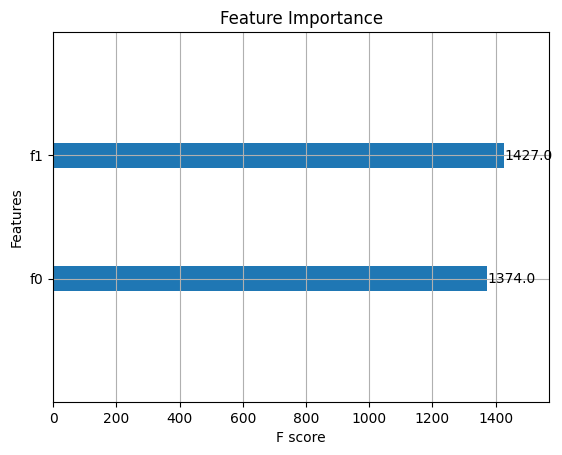

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import cv


# Ensure the target column is filled
df["MDS Simplified"] = df["MDS Simplified"].fillna("")
label_encoder = LabelEncoder()

# Fit learns the mapping from categorial labels to int 
y = label_encoder.fit_transform(df["MDS Simplified"])

# X is the numerical embeddings of the other columns, use high-dimensionality embeddings
X = high_dimensionality_embeddings_original

# Split into training and testing sets (80% training 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into DMatrix format
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Set XGBoost parameters for multiclass classification (previous was for regression)
xgb_params = {
    "objective": "multi:softprob", # multi-class classification
    "num_class": len(label_encoder.classes_), # number of unique classes in y
    "eval_metric": "mlogloss", # multi-class log loss, measures model performance during training
    "max_depth": 5, # max depth of decision trees
    "eta": 0.1,  # Learning rate
    "subsample": 0.8, # proportion of training data used for each tree
    "colsample_bytree": 0.8, # proportion of features used for each tree
    "lambda": 1.0,  # L2 regularization to prevent overfitting
}

# Train the XGBoost model
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=81, # trains up to 81 trees (cross validaition suggestion)
    evals=[(dtrain, "train"), (dtest, "test")], # evaluates performance on both training and testing data at each round
    early_stopping_rounds=10, # stops training if log less validation metric doesn't improve for 10 rounds
    verbose_eval=10, # prints training progress every 10 rounds
)

# Make predictions with XGBoost
xgb_preds = xgb_model.predict(dtest)

# Convert probabilities to class labels
y_pred = np.argmax(xgb_preds, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

# cv_results = xgb.cv(
#     params=xgb_params,
#     dtrain=dtrain,
#     num_boost_round=100,
#     nfold=5,
#     metrics=["mlogloss"],
#     early_stopping_rounds=10,
#     verbose_eval=10,
# )
# print(cv_results)

# Predict probabilities for test data
xgb_preds = xgb_model.predict(xgb.DMatrix(X_test))

# Convert probabilities to predicted classes
y_pred = np.argmax(xgb_preds, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Log Loss
test_log_loss = log_loss(y_test, xgb_preds, labels=np.arange(len(label_encoder.classes_)))

# Generate a classification report
classification_rep = (classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = (confusion_matrix(y_test, y_pred))

# Print Results for Readability
print("\n========== MODEL RESULTS ==========")
print(f"Accuracy: {accuracy:.4f}")
print(f"Log-Loss (Test): {test_log_loss:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot feature importance
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Feature Importance")
plt.show()

In [ ]:
import inspect
print(inspect.signature(lgb.train))

(params: Dict[str, Any], train_set: lightgbm.basic.Dataset, num_boost_round: int = 100, valid_sets: Optional[List[lightgbm.basic.Dataset]] = None, valid_names: Optional[List[str]] = None, feval: Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]], List[Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]]]], NoneType] = None, init_model: Union[str, pathlib.Path, lightgbm.basic.Booster, NoneType] = None, feature_name: Union[List[str], ForwardRef("Literal['auto']")] = 'auto', categorical_feature: Union[List[str], List[int], ForwardRef("Literal['auto']")] = 'auto', keep_training_booster: bool = False, callbacks: Optional[List[Callable]] = None) -> lightgbm.basic.Booster


In [ ]:
pip list | grep lightgbm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


lightgbm                  4.5.0
Note: you may need to restart the kernel to use updated packages.


**Catboost**

0:	learn: 2.0109432	test: 2.0243136	best: 2.0243136 (0)	total: 59.2ms	remaining: 5.86s
10:	learn: 1.0661026	test: 0.9833027	best: 0.9833027 (10)	total: 67.3ms	remaining: 545ms
20:	learn: 0.7389171	test: 0.6262002	best: 0.6262002 (20)	total: 75.6ms	remaining: 284ms
30:	learn: 0.5847620	test: 0.4619004	best: 0.4619004 (30)	total: 83.9ms	remaining: 187ms
40:	learn: 0.4941826	test: 0.3744679	best: 0.3744679 (40)	total: 92.5ms	remaining: 133ms
50:	learn: 0.4334897	test: 0.3230041	best: 0.3230041 (50)	total: 101ms	remaining: 97.1ms
60:	learn: 0.3865557	test: 0.2920587	best: 0.2920587 (60)	total: 109ms	remaining: 69.5ms
70:	learn: 0.3503190	test: 0.2678311	best: 0.2678311 (70)	total: 116ms	remaining: 47.5ms
80:	learn: 0.3203283	test: 0.2499163	best: 0.2499163 (80)	total: 123ms	remaining: 28.9ms
90:	learn: 0.2952117	test: 0.2374849	best: 0.2374849 (90)	total: 130ms	remaining: 12.9ms
99:	learn: 0.2739859	test: 0.2303621	best: 0.2303621 (99)	total: 137ms	remaining: 0us

bestTest = 0.2303621353
b

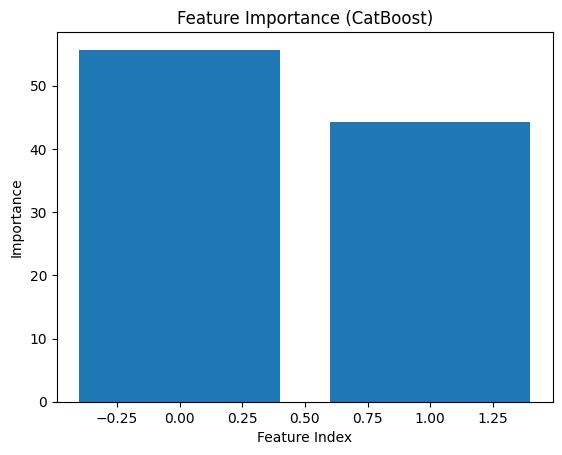

In [ ]:
from catboost import CatBoostClassifier

# Ensure the target column is filled
df["MDS Simplified"] = df["MDS Simplified"].fillna("")
label_encoder = LabelEncoder()

# Fit learns the mapping from categorical labels to int 
y = label_encoder.fit_transform(df["MDS Simplified"])

# X is the numerical embeddings of the other columns, use high-dimensionality embeddings
X = high_dimensionality_embeddings_original

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CatBoost model for multi-class classification
catboost_model = CatBoostClassifier(
    iterations=100,               # Number of boosting rounds
    learning_rate=0.1,            # Learning rate
    depth=6,                      # Tree depth
    loss_function="MultiClass",   # Multi-class classification objective
    verbose=10,                   # Print training progress every 10 iterations
    random_seed=42,               # For reproducibility
    early_stopping_rounds=10      # Stop if no improvement for 10 iterations
)

# Train the CatBoost model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Make predictions with CatBoost (class probabilities)
catboost_preds_prob = catboost_model.predict_proba(X_test)

# Convert probabilities to predicted classes
y_pred = catboost_model.predict(X_test)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Log Loss
test_log_loss = log_loss(y_test, catboost_preds_prob, labels=np.arange(len(label_encoder.classes_)))

# Generate a classification report
classification_rep = classification_report(y_test, y_pred)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results for Readability
print("\n========== MODEL RESULTS ==========")
print(f"Accuracy: {accuracy:.4f}")
print(f"Log-Loss (Test): {test_log_loss:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

# Feature Importance Visualization
feature_importances = catboost_model.get_feature_importance()
plt.bar(range(len(feature_importances)), feature_importances)
plt.title("Feature Importance (CatBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

**LightGBM**

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 180, number of used features: 2
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.148434
[LightGBM] [Info] Start training from score -2.101914
[LightGBM] [Info] Start training from score -2.628007
[LightGBM] [Info] Start training from score -4.094345
[LightGBM] [Info] Start training from score -1.825661
[LightGBM] [Info] Start training from score -1.241713
[LightGBM] [Info] Start training from score -4.499810
[LightGBM] [Info] Start training from score -2.057463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

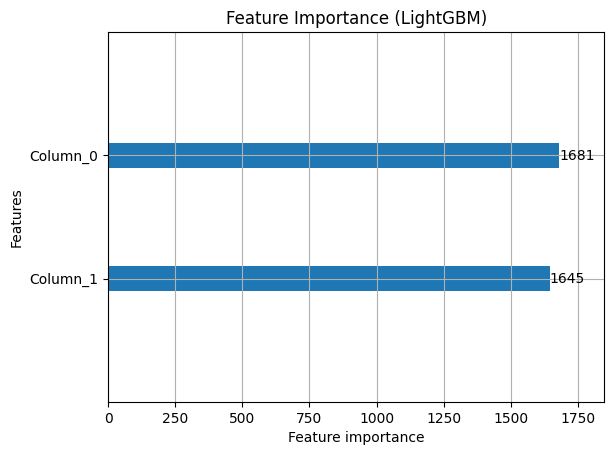

In [ ]:
import lightgbm as lgb

# Ensure the target column is filled
df["MDS Simplified"] = df["MDS Simplified"].fillna("")
label_encoder = LabelEncoder()

# Fit learns the mapping from categorical labels to int 
y = label_encoder.fit_transform(df["MDS Simplified"])

# X is the numerical embeddings of the other columns, use high-dimensionality embeddings
X = high_dimensionality_embeddings_original

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define LightGBM parameters for multi-class classification
lgb_params = {
    "objective": "multiclass",  # Multi-class classification objective
    "num_class": len(label_encoder.classes_),  # Number of unique classes in y
    "metric": "multi_logloss",  # Multi-class log-loss
    "learning_rate": 0.1,  # Learning rate
    "max_depth": 6,  # Maximum depth of trees
    "num_leaves": 31,  # Number of leaves in each tree
    "feature_fraction": 0.8,  # Fraction of features used per tree
    "bagging_fraction": 0.8,  # Fraction of data used per iteration
    "lambda_l2": 1.0,  # L2 regularization to prevent overfitting
    "random_state": 42,  # Seed for reproducibility
}

# Train the LightGBM model with early stopping
lgb_model = lgb.train(
    params=lgb_params,
    train_set=train_data,
    num_boost_round=100,  # Maximum number of boosting iterations
    valid_sets=[train_data, test_data],  # Evaluate on both train and test sets
     # Print progress every 10 iterations
)

# Make predictions with LightGBM
lgb_preds_prob = lgb_model.predict(X_test)

# Convert probabilities to predicted classes
y_pred = lgb_preds_prob.argmax(axis=1)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Log Loss
test_log_loss = log_loss(y_test, lgb_preds_prob, labels=np.arange(len(label_encoder.classes_)))

# Generate a classification report
classification_rep = classification_report(y_test, y_pred)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results for Readability
print("\n========== MODEL RESULTS ==========")
print(f"Accuracy: {accuracy:.4f}")
print(f"Log-Loss (Test): {test_log_loss:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("Feature Importance (LightGBM)")
plt.show()

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
for i, embedding in enumerate(embedding_list_original):
    if embedding.size == 0:
        print(f"Embedding {i+1} is empty.")
    elif np.all(embedding == 0):
        print(f"Embedding {i+1} contains only zeros.")
    else:
        print(f"Embedding {i+1} is valid with shape {embedding.shape}.")

print("Feature names:", train_data.feature_name)

X_train shape: (180, 2)
X_test shape: (45, 2)
Embedding 1 is valid with shape (225, 2).
Embedding 2 is valid with shape (225, 768).
Embedding 3 is valid with shape (225, 2).
Embedding 4 is valid with shape (225, 2).
Embedding 5 is valid with shape (225, 2).
Embedding 6 is valid with shape (225, 2).
Embedding 7 is valid with shape (225, 2).
Embedding 8 is valid with shape (225, 2).
Embedding 9 is valid with shape (225, 2).
Embedding 10 is valid with shape (225, 2).
Embedding 11 is valid with shape (225, 2).
Embedding 12 is valid with shape (225, 2).
Feature names: ['Column_0', 'Column_1']
